# Homework08

Exercises to practice unsupervised learning with clustering

## Goals

- Get more practice with the ML flow: encode -> normalize -> train -> evaluate
- Understand the tradeoffs of modeling parameters
- Develop intuition for different clustering models and when to use them

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [2]:
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/data_utils.py
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/image_utils.py

In [3]:
import json
import matplotlib.pyplot as plt
import pandas as pd

from os import listdir
from PIL import Image as PImage

from sklearn.preprocessing import OrdinalEncoder

from data_utils import object_from_json_url
from data_utils import StandardScaler
from data_utils import KMeansClustering, GaussianClustering

from image_utils import get_pixels, make_image

## Helmet Sizing

### Load Dataset

Let's load up the full [ANSUR](https://www.openlab.psu.edu/ansur2/) dataset that we looked at briefly in [Week 02](https://github.com/PSAM-5020-2025S-A/WK02) and then again in [Homework06](https://github.com/PSAM-5020-2025S-A/Homework06).

This is the dataset that has anthropometric information about U.S. Army personnel.

#### WARNING

Like we mentioned in class, this dataset is being used for these exercises due to the level of detail in the dataset and the rigorous process that was used in collecting the data.

This is a very specific dataset and should not be used to draw general conclusions about people, bodies, or anything else that is not related to the distribution of physical features of U.S. Army personnel.

In [4]:
# Load Dataset
ANSUR_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025S-A/5020-utils/main/datasets/json/ansur.json"
ansur_data = object_from_json_url(ANSUR_FILE)

# Look at first 2 records
ansur_data[:2]

[{'age': 18,
  'gender': 'F',
  'height': 66,
  'weight': 135,
  'span': 1699,
  'stature': 1645,
  'ear': {'breadth': 30, 'length': 61, 'protrusion': 20},
  'foot': {'breadth': 97, 'length': 243},
  'hand': {'breadth': 78, 'length': 182, 'palm': 108},
  'head': {'height': 243, 'circumference': 557}},
 {'age': 30,
  'gender': 'M',
  'height': 68,
  'weight': 207,
  'span': 1749,
  'stature': 1715,
  'ear': {'breadth': 35, 'length': 63, 'protrusion': 17},
  'foot': {'breadth': 100, 'length': 252},
  'hand': {'breadth': 87, 'length': 184, 'palm': 114},
  'head': {'height': 238, 'circumference': 560}}]

Let's load it into a `DataFrame`, like last week.

In [5]:
# Read into DataFrame
ansur_df = pd.json_normalize(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference
0,18,F,66,135,1699,1645,30,61,20,97,243,78,182,108,243,557
1,30,M,68,207,1749,1715,35,63,17,100,252,87,184,114,238,560
2,27,M,67,121,1684,1657,36,59,24,92,251,84,180,103,239,516
3,20,M,73,185,1878,1828,36,60,21,104,280,95,201,124,270,582
4,33,M,76,150,1977,1883,39,65,27,101,271,90,194,113,254,559


### Unsupervised Learning

Let's pretend we are designing next-generation helmets with embedded over-the-ear headphones and we want to have a few options for sizes.

We could use clustering to see if there is a number of clusters that we can divide our population into, so each size covers a similar portion of the population.

We can follow similar steps to regression to create a clustering model that uses features about head and ear sizes:

1. Load dataset (done! 🎉)
2. Encode label features as numbers
3. Normalize the data
4. Separate the feature variables we want to consider (done below)
5. Pick a clustering algorithm
6. Determine number of clusters
7. Cluster data
8. Interpret results

For step $5$, it's fine to just pick an algorithm ahead of time to see what happens, but feel free to experiment and plot results for multiple clustering methods.

In [6]:
## Encode non-numerical features
gender = ['F', 'M']
gender_encoder = OrdinalEncoder(categories=[gender])
gender_vals = gender_encoder.fit_transform(ansur_df[["gender"]].values)
ansur_df[["gender"]] = gender_vals.astype(int)
display(ansur_df)


,age,gender,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference
0,18,0,66,135,1699,1645,30,61,20,97,243,78,182,108,243,557
1,30,1,68,207,1749,1715,35,63,17,100,252,87,184,114,238,560
2,27,1,67,121,1684,1657,36,59,24,92,251,84,180,103,239,516
3,20,1,73,185,1878,1828,36,60,21,104,280,95,201,124,270,582
4,33,1,76,150,1977,1883,39,65,27,101,271,90,194,113,254,559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5595,43,0,62,140,1565,1561,39,69,26,89,246,80,178,98,232,561
5596,24,1,70,230,1826,1781,31,62,23,104,287,92,194,122,260,584
5597,27,1,68,238,1735,1731,37,58,24,104,268,88,179,112,243,574
5598,23,1,71,160,1839,1786,38,63,22,98,269,90,195,115,235,561


In [7]:
## Normalize the data
ansur_scaler = StandardScaler()
ansur_scaled_df = ansur_scaler.fit_transform(ansur_df)

In [8]:
## Separate the features we want to consider
ansur_features = ansur_scaled_df[["head.height", "head.circumference", "ear.length", "ear.breadth", "ear.protrusion"]]

In [9]:
## Create Kmeans Clustering model
km_model = KMeansClustering(n_clusters=3, random_state=1010)

## Run the model(s) on the data
km_predicted = km_model.fit_predict(ansur_features)

## Check errors
print("KMeans objective score:", km_model.score(ansur_features.values))


KMeans objective score: -17080.253156572173


In [10]:
## Create Gaussian Clustering model
gs_model = GaussianClustering(n_clusters=3, random_state=1010)

## Run the model(s) on the data
gs_predicted = gs_model.fit_predict(ansur_features)

## Check errors
print("Gaussian likelihood score:", gs_model.score(ansur_features.values))

Gaussian likelihood score: -6.578969540307851


In [11]:
features_cov = ansur_features.cov()
for i in range(len(features_cov)):
  features_cov.iloc[i,i] = 0

display(ansur_features.cov().abs().min())
display(ansur_features.cov().abs().idxmin())

head.height           0.273468
head.circumference    0.124790
ear.length            0.283878
ear.breadth           0.221058
ear.protrusion        0.124790
dtype: float64

head.height               ear.protrusion
head.circumference        ear.protrusion
ear.length            head.circumference
ear.breadth           head.circumference
ear.protrusion        head.circumference
dtype: object

In [12]:
## Plot clusters as function of 2 or 3 variables

def plot_clusters(features, labels, clusters, title):
  xl, yl, zl = labels[:3]
  x = features[xl]
  y = features[yl]
  z = features[zl]

  # 2D
  plt.scatter(x, y, c=clusters, marker='o', linestyle='', alpha=0.5)
  plt.title(f"{title} clustering")
  plt.xlabel(xl)
  plt.ylabel(yl)
  plt.ylim([-2.2, 3])
  plt.show()

  plt.scatter(x, z, c=clusters, marker='o', linestyle='', alpha=0.5)
  plt.title(f"{title} clustering")
  plt.xlabel(xl)
  plt.ylabel(zl)
  plt.ylim([-2.2, 3])
  plt.show()

  # 3D
  fig = plt.figure(figsize=(8, 8))
  ax = fig.add_subplot(projection='3d')

  ax.scatter(x, y, z, c=clusters, marker='o', linestyle='', alpha=0.5)

  ax.set_title(f"{title} clustering")
  ax.set_xlabel(xl)
  ax.set_ylabel(yl)
  ax.set_zlabel(zl)
  ax.set_ylim(-2.5, 8)
  ax.set_zlim(-2.5, 2.5)

  plt.show()

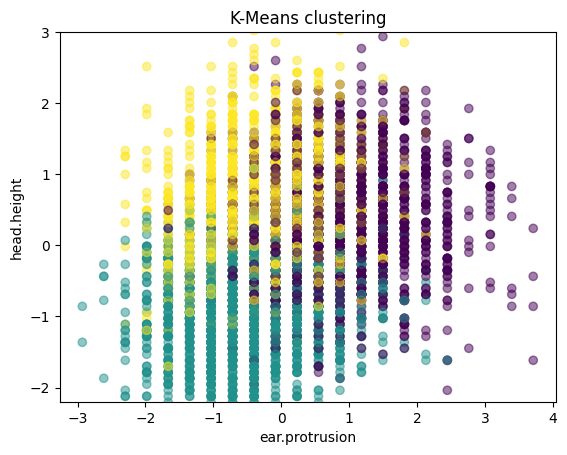

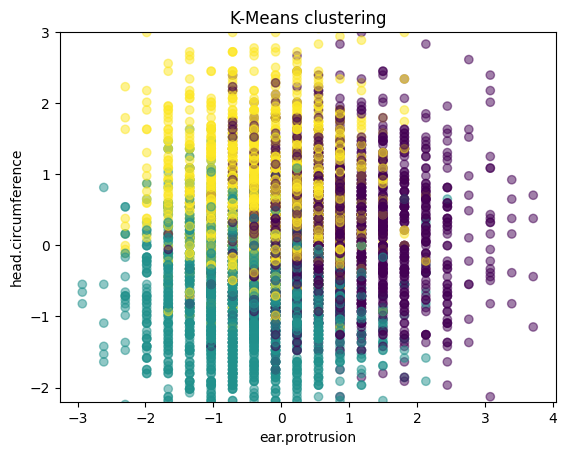

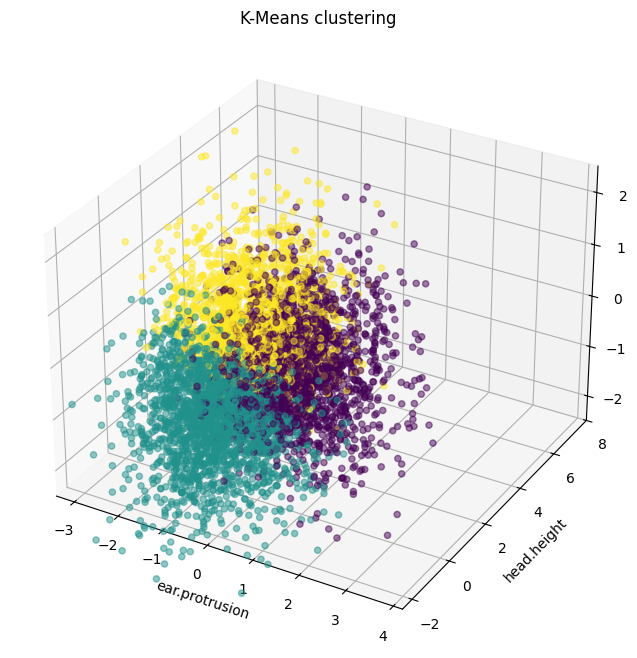

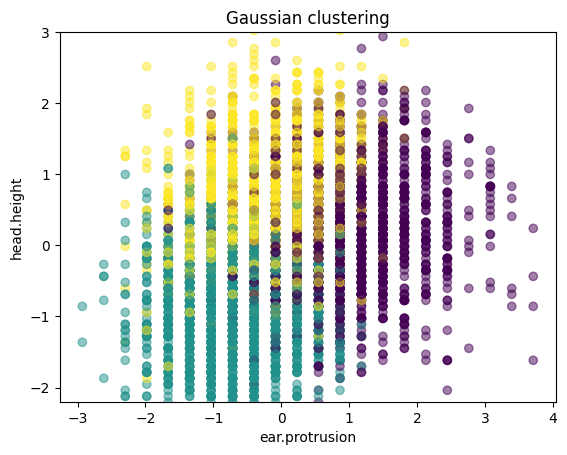

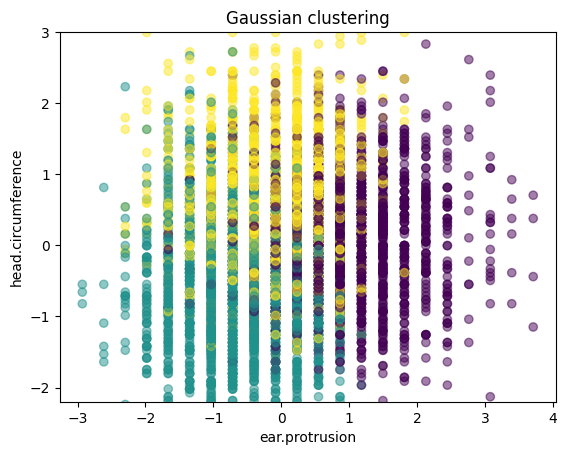

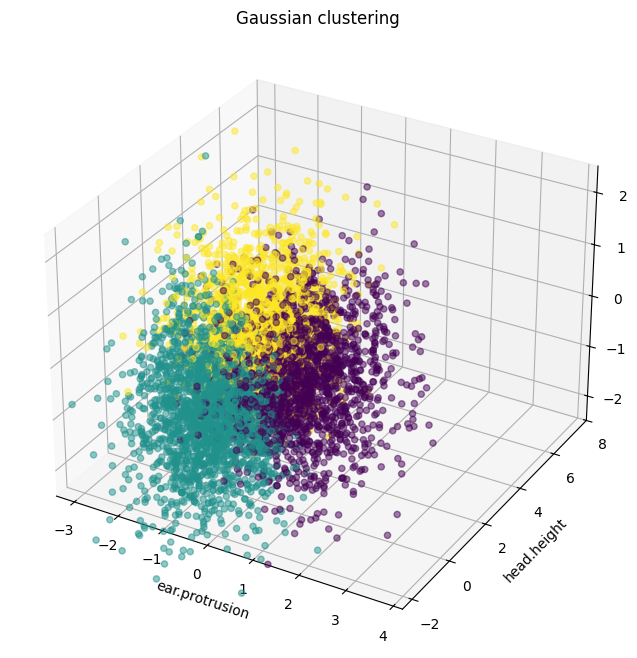

In [13]:
# For plotting
labels = ["ear.protrusion", "head.height", "head.circumference"]
km_clusters = km_predicted["clusters"]
gs_clusters = gs_predicted["clusters"]

plot_clusters(ansur_features, labels, km_clusters, "K-Means")
plot_clusters(ansur_features, labels, gs_clusters, "Gaussian")

### Interpretation

<span style="color:hotpink;">
Which clustering algorithm did you choose?<br>
Did you try a different one?<br>
Do the clusters make sense ? Do they look balanced ?
</span>

<span style="color:lime;">
ANSWER:<br>
I tried both K-Mean and Gaussian. I can't really tell the different by my eyes, but the number of score are different. First time I use n-cluster = 7 It's quite difficult to separate the cluster. When I adjust the cluster down, it make more balance.
</span>

## Figure out how many cluster

Experiment with the number of clusters to see if the initial choice makes sense.

The [WK08](https://github.com/PSAM-5020-2025S-A/WK08) notebook had a for loop that can be used to plot errors versus number of clusters.

In [14]:
## Plot errors and pick how many cluster

print("KMeans distance score:", km_model.distance_score())
print("Gaussian distance score:", gs_model.distance_score())

print("KMeans balance score:", km_model.balance_score())
print("Gaussian balance score:", gs_model.balance_score())

print("KMeans silhouette score:", km_model.silhouette_score())
print("Gaussian silhouette score:", gs_model.silhouette_score())

KMeans distance score: 1.650925379248208
Gaussian distance score: 1.6723504970672558
KMeans balance score: 0.9669642857142857
Gaussian balance score: 0.9653571428571429
KMeans silhouette score: 0.19069090701194621
Gaussian silhouette score: 0.17865415249551594


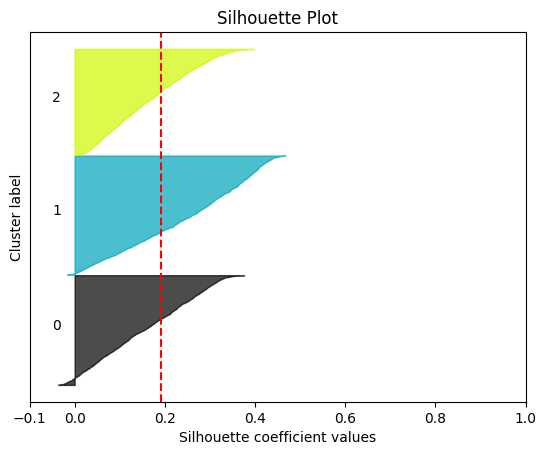

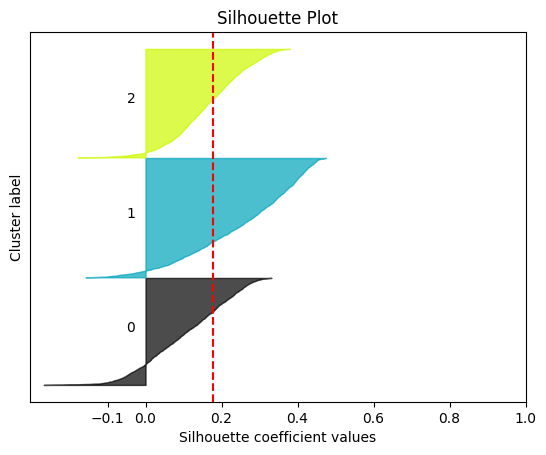

In [15]:
km_model.plot_silhouette()
gs_model.plot_silhouette()

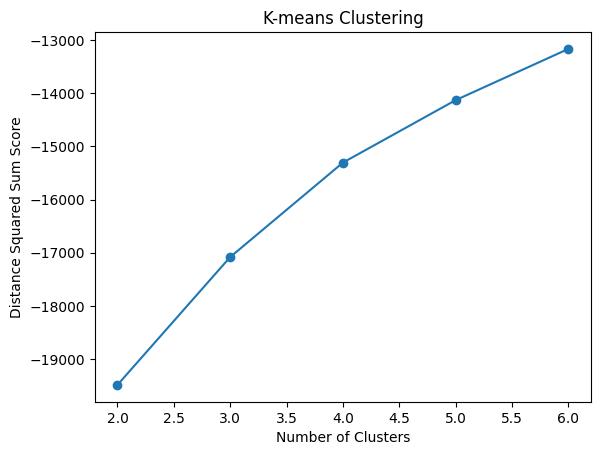

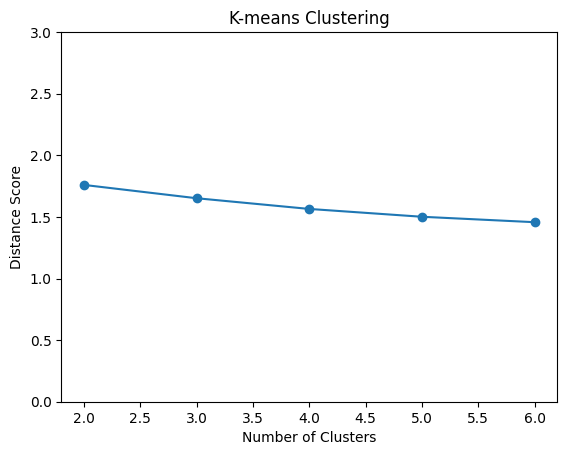

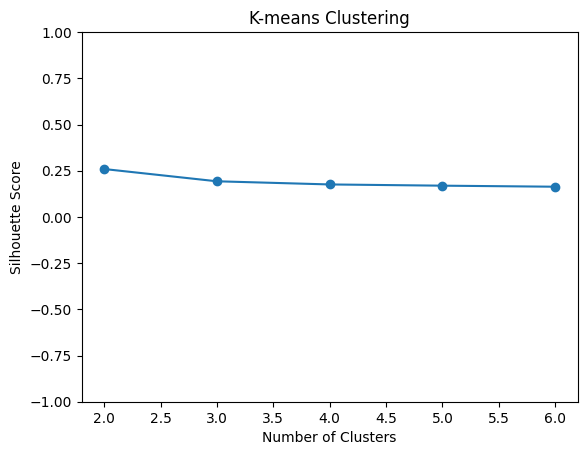

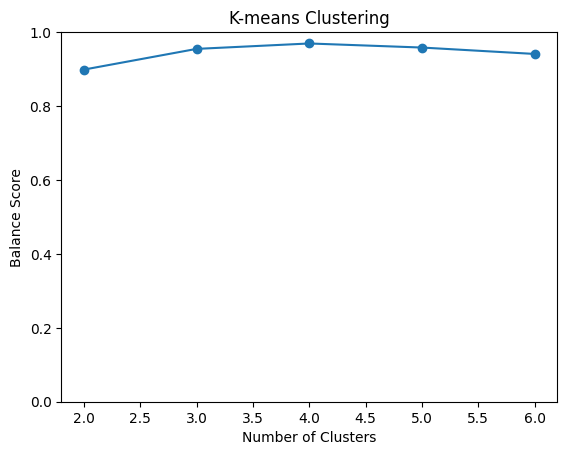

In [16]:

# try 2 - 10 clusters for K-Means Clustering
num_clusters = list(range(2,7))

# collect distance, silhouette and balance scores
score_scores = []
distance_scores = []
silhouette_scores = []
balance_scores = []

# get distance, likelihood and balance for different clustering sizes
for n in num_clusters:
  mm = KMeansClustering(n_clusters=n)
  mm.fit_predict(ansur_features)
  score_scores.append(mm.score(ansur_features.values))
  distance_scores.append(mm.distance_score())
  silhouette_scores.append(mm.silhouette_score())
  balance_scores.append(mm.balance_score())

# plot scores as function of number of clusters
plt.plot(num_clusters, score_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Distance Squared Sum Score")
plt.title("K-means Clustering")
# plt.ylim([0, 3])
plt.show()

plt.plot(num_clusters, distance_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Distance Score")
plt.title("K-means Clustering")
plt.ylim([0, 3])
plt.show()

plt.plot(num_clusters, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("K-means Clustering")
plt.ylim([-1, 1])
plt.show()

plt.plot(num_clusters, balance_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Balance Score")
plt.title("K-means Clustering")
plt.ylim([0, 1])
plt.show()

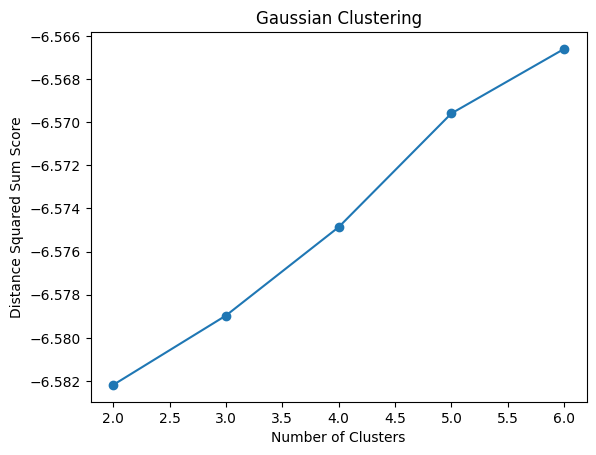

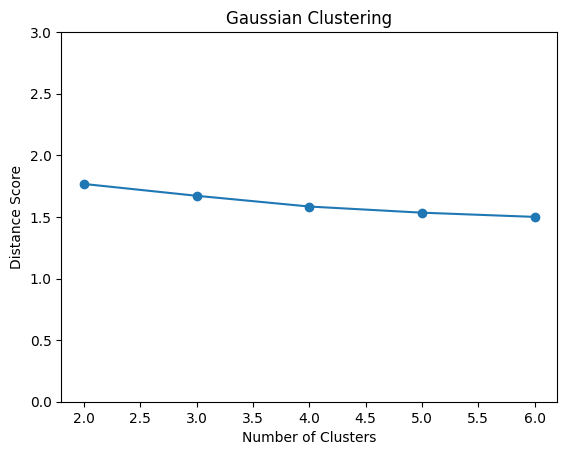

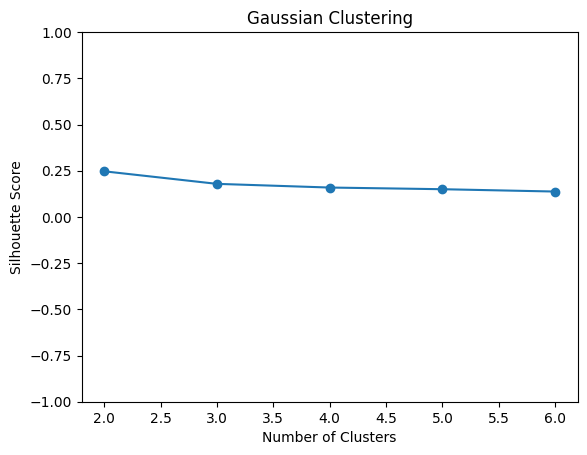

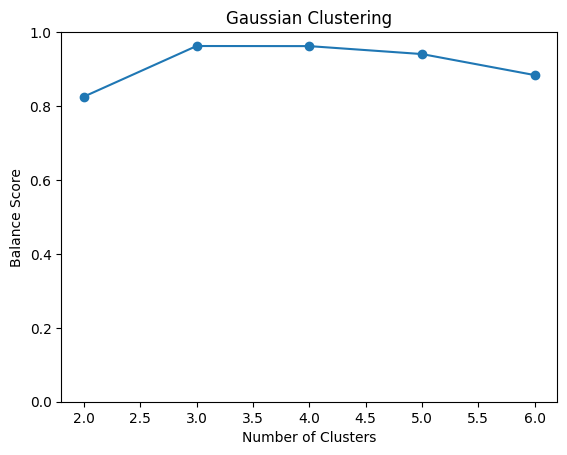

In [17]:

# try  for Gaussian Clustering
num_clusters = list(range(2,7))

# collect distance, silhouette and balance scores
score_scores = []
distance_scores = []
silhouette_scores = []
balance_scores = []

# get distance, likelihood and balance for different clustering sizes
for n in num_clusters:
  mm = GaussianClustering(n_clusters=n)
  mm.fit_predict(ansur_features)
  score_scores.append(mm.score(ansur_features.values))
  distance_scores.append(mm.distance_score())
  silhouette_scores.append(mm.silhouette_score())
  balance_scores.append(mm.balance_score())

# plot scores as function of number of clusters
plt.plot(num_clusters, score_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Distance Squared Sum Score")
plt.title("Gaussian Clustering")
# plt.ylim([0, 3])
plt.show()

plt.plot(num_clusters, distance_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Distance Score")
plt.title("Gaussian Clustering")
plt.ylim([0, 3])
plt.show()

plt.plot(num_clusters, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Gaussian Clustering")
plt.ylim([-1, 1])
plt.show()

plt.plot(num_clusters, balance_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Balance Score")
plt.title("Gaussian Clustering")
plt.ylim([0, 1])
plt.show()

### Interpretation

<span style="color:hotpink;">
Based on the graphs of errors versus number of clusters, does it look like we should change the initial number of clusters ?<br>
How many clusters should we use ? Why ?
</span>

<span style="color:lime;">ANSWER:<br>
The graph not show the significantly different in the distance and silhouette score. In balance score, the graph going up to 3 and go down again after that, so I think 3 clusters might be enough.
</span>

### Revise Number of Clusters.

Re-run with the new number of clusters and plot the data in $2D$ or $3D$.

This can be the same graph as above.

KMeans silhouette score: 0.19069090701194621


Gaussian silhouette score: 0.17865415249551594


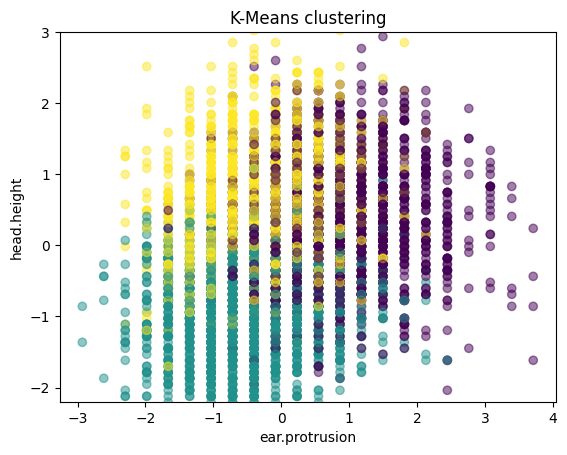

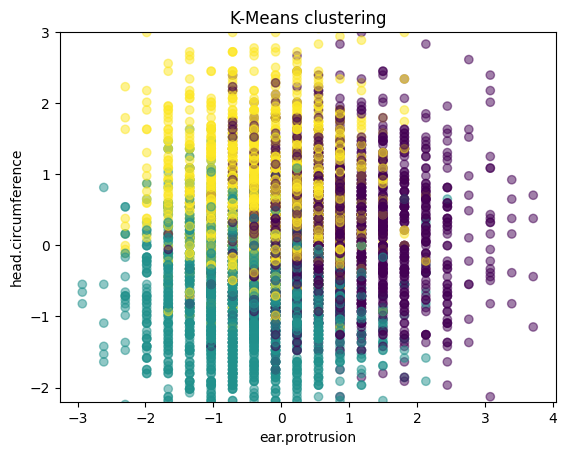

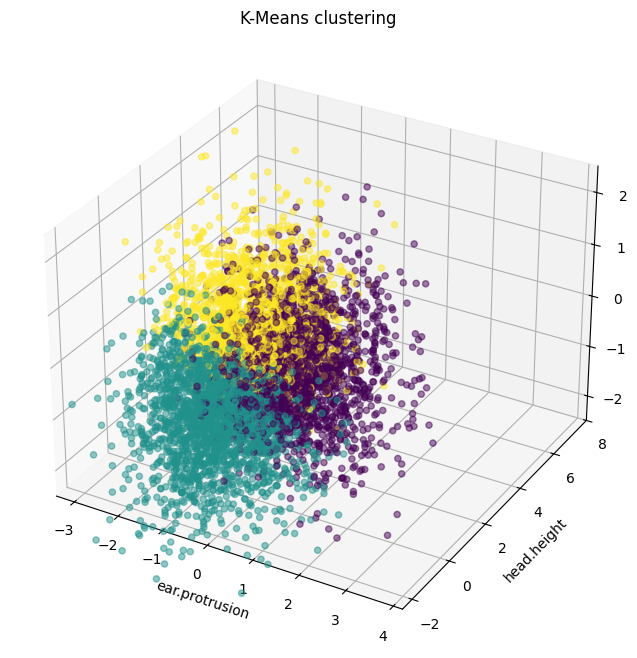

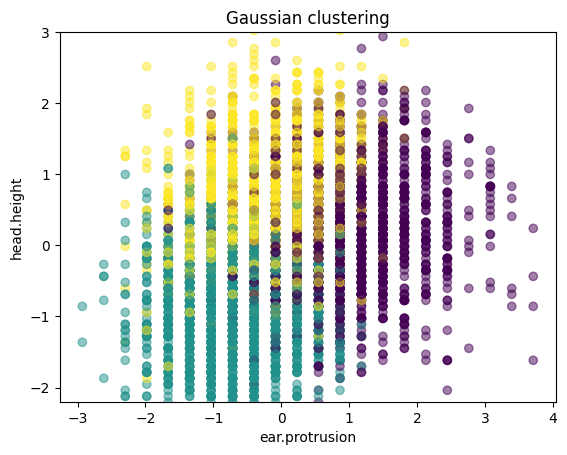

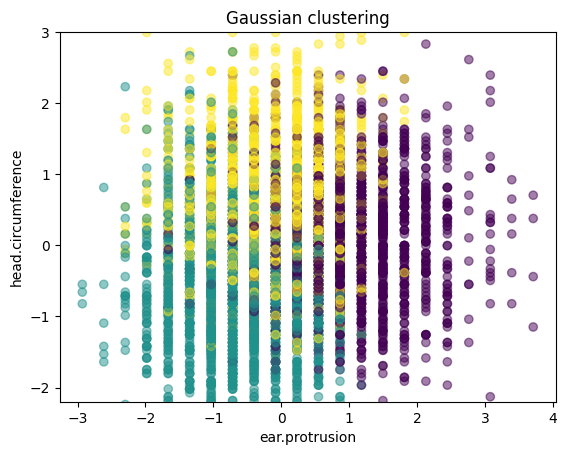

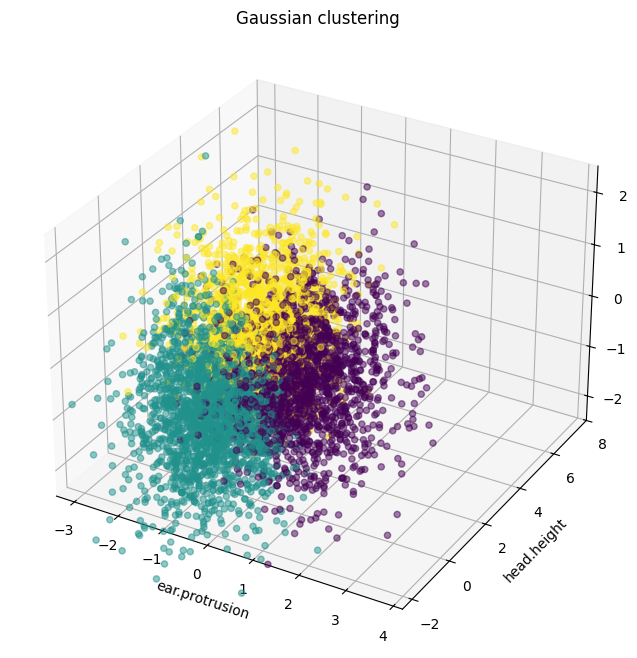

In [18]:
## Re-run clustering with final number of clusters
# rerun above - changed n-cluster from 5 to 3, so it look the same here

## Run the model on the training data
labels = [ "ear.protrusion","head.height", "head.circumference"]
km_clusters = km_predicted["clusters"]
gs_clusters = gs_predicted["clusters"]

## Check errors
print("KMeans silhouette score:", km_model.silhouette_score())
print("Gaussian silhouette score:", gs_model.silhouette_score())

## Plot in 3D
plot_clusters(ansur_features, labels, km_clusters, "K-Means")
plot_clusters(ansur_features, labels, gs_clusters, "Gaussian")


### Interpretation

<span style="color:hotpink;">
Do these look better than the original number of clusters?
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>

## Image Organization

We have a dataset of about $600$ flower images that we might want to classify by species... eventually.

What we want to do first is take a look at all of the images and see what kind of images we have, what kind of colors our flowers have and see if there's any other visual information that could help us classify these images later.

We'll see how to use clustering and distances to organize our images by color to create a visualization that we cna use to get to know our dataset.

### Load Dataset

The following cell downloads the dataset:

In [19]:
!wget -qO- https://github.com/PSAM-5020-2025S-A/5020-utils/releases/latest/download/flowers.tar.gz | tar xz

Then, we can take a look at a few of the images:

In [20]:
IMG_DIR = "./data/image/flowers"

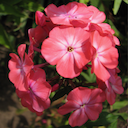

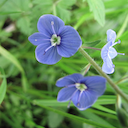

In [21]:
display(PImage.open(f"{IMG_DIR}/00_001.png"))
display(PImage.open(f"{IMG_DIR}/15_001.png"))

### Find Representative Colors

The overall process for organizing our images by color will be something like this:

1. Iterate over all files in the `data/image/flowers` directory, open each image file and treat it as a dataset
   1. Load image into a `DataFrame` where each pixel is a row and R,G,B values are columns/features
   2. Cluster into $2$ - $16$ colors
   3. Pick $3$ or $4$ representative colors
   4. Store image filenames and their representative colors in a Python object
2. Once all images have been processed we can order our dataset by different color characteristics: white to black, red to blue, hue value, brightness

### One Image

Let's step through the process of getting representative colors for one image, and then we can repeat this in a loop to process all of the flower images.

#### Open Image

The `PIL` library does all the work here:

In [22]:
# Open image
fname = "00_001.png"
pimg = PImage.open(f"{IMG_DIR}/{fname}").convert("RGB")

#### Put into `DataFrame`

We get the pixels and make a dataset/`DataFrame` out of them:

In [23]:
# Load into DataFrame
pxs = get_pixels(pimg)
pxs_df = pd.DataFrame(pxs, columns=["R", "G", "B"])

In [24]:
pxs_df

,R,G,B
0,13,22,10
1,14,23,9
2,16,24,10
3,16,24,11
4,16,24,10
...,...,...,...
16379,85,61,57
16380,70,48,44
16381,59,38,38
16382,26,25,16


#### Cluster colors

Create a clustering object, cluster colors into $8$ clusters with `fit_predict()` and take a look at our color palette (`cluster_centers_`):

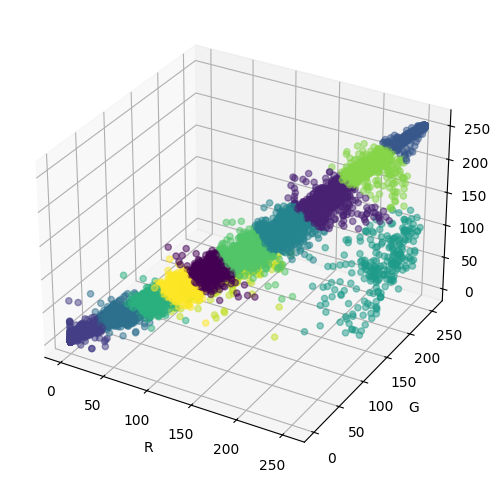

[[102.34539904055822, 94.72786742259049, 84.1491495856956],
 [187.18364611260054, 180.63806970509384, 166.46246648793564],
 [10.726881720430107, 11.403225806451612, 10.897849462365592],
 [246.4141935483871, 246.35870967741934, 245.30967741935484],
 [34.07719714964371, 36.604513064133016, 27.68349168646081],
 [157.1688034188034, 150.09188034188034, 131.23611111111111],
 [235.91701244813277, 202.22821576763485, 71.51452282157676],
 [57.95847902097902, 58.60183566433567, 46.67657342657343],
 [126.51567498400512, 119.20793346129238, 103.79782469609725],
 [217.48793284365163, 215.20461699895068, 206.6956977964323],
 [85.50088809946715, 126.81882770870338, 39.698046181172295],
 [80.44721998388397, 75.03021756647864, 65.75745366639806]]

In [45]:
# TODO: Create Clustering object
n = 12
km_img_model = KMeansClustering(n_clusters=n, random_state=1010)

# TODO: Cluster by color
px_clusters_df = km_img_model.fit_predict(pxs_df)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(pxs_df["R"], pxs_df["G"], pxs_df["B"], c=px_clusters_df, marker='o', linestyle='', alpha=0.5)
ax.set_xlabel("R")
ax.set_ylabel("G")
ax.set_zlabel("B")
plt.show()

# TODO: Take a look at the color palette (cluster_centers_)
km_img_model.cluster_centers_


#### Checkpoint

<span style="color:hotpink;">
Does anything stand out about the colors?
</span>

<span style="color:lime;">ANSWER: The colors cluster looks very clear from each other in 8 groups</span>

#### Reconstruct Image

Since we're only doing one image for now, let's take a look at the clustering result.

This is like in the lecture notebook. We'll start with an empty pixel array and as we iterate through the `DataFrame` of cluster ids we append the corresponding colors to it.

In [26]:
# TODO: create empty pixel array
pxs_post = []

# TODO: iterate through resulting list of cluster ids
color_centers = [[round(r), round(g), round(b)] for r,g,b in km_img_model.cluster_centers_]

# TODO: append corresponding color value to pixel array
for p in px_clusters_df["clusters"]:
  pxs_post.append(color_centers[p])

pxs_post[:5]


[[20, 22, 14], [20, 22, 14], [20, 22, 14], [20, 22, 14], [20, 22, 14]]

Now we can look at the image. If this next cell gives errors about using `float` values in images, just make sure the pixel values that are being appended above are all whole number `int` values.

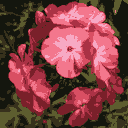

In [27]:
display(make_image(pxs_post, width=pimg.size[0]))

#### Checkpoint

<span style="color:hotpink;">
How does changing the number of clusters affect the resulting image?<br>Try some lower values like <code>2</code> and <code>4</code>, and also some higher ones like <code>12</code> and <code>16</code>. Take a look at a different image.
</span>

<span style="color:lime;">
ANSWER: <br>
When less than 5, it looks flat like 2d image and no depth dimension <br>
When it's more than 12, it looks like cells duplicate itself - separate and find the new center close to each other
</span>

#### Pick Colors

Ok, we have some representative colors for our images. We should keep more than one color, but maybe we don't have to keep $12$.

We can use the `value_counts()` function of our `DataFrame` to see how many pixels are represented by each of our cluster colors:

In [28]:
# cluster ids and pixel counts, ordered by descending counts
ccounts = px_clusters_df["clusters"].value_counts()
display(ccounts)

clusters
7    3856
1    2261
0    2199
2    2197
3    1916
6    1602
5    1473
4     880
Name: count, dtype: int64

Since what we are really trying to do here is get some information about the colors of the flowers present in our images, and given the type of images we have, we can start by assuming that the flower colors will be in the top-$4$ clusters returned by `value_counts()`.

We can revisit this assumption later. We might also want to add some filters here to ignore sky and vegetation colors (blues and greens) and only keep flower colors.

For now, let's just grab the top-$4$ colors from `value_counts()`, remembering we want to keep their rounded `int` values and not the default `float` values in `cluster_centers_`.

In [29]:
# List to keep colors for each file
file_colors = []

# TODO: go through ccounts.index and get corresponding colors for clusters
for p in ccounts.index[:4]:
    
# TODO: add top-4 colors to the file_colors object
    file_colors.append(color_centers[p])

In [30]:
display(file_colors)

[[20, 22, 14], [55, 49, 28], [243, 119, 141], [122, 32, 42]]

#### Checkpoint

<span style="color:hotpink;">
Why might we want to cluster into <code>8</code> or even <code>12</code> colors when in the end we're only keeping <code>4</code>?
</span>

<span style="color:lime;">ANSWER:<br>
Because we need to separate the color first before pick the right one. If we're not make a cluster to 8 or more, we can't get acurrate color in spectrum, for example purple color might go in to red or blue.
</span>

### Iterate and Cluster

We've processed one image, now let's process $600$... for-loops FTW!

We'll need to loop through all of the images in our directory and repeat the process above for each one of them.

We can create a function that takes a filename as input and returns the top-$4$ colors for that image, or... we can just put all of the clustering logic in the body of a for loop. Whichever is easiest.

Let's get started.

In [31]:
# list of all files in the flowers directory
flower_files = sorted([f for f in listdir(IMG_DIR) if f.endswith(".png")])

Here's the loop. In the end we want our `file_colors` list to have objects that have a filename and $4$ colors associated with each filename. Something like:

```py
[
  {
    "filename": "00_001.png",
    "colors": [[12,44,12], [112,144,62],  [12,84,112], [212,144,102]]
  },
  {
    "filename": "00_002.png",
    "colors": [[22,24,28], [112,114,122], [128,200,2], [250,240,230]]
  },
  ...
]
```

This can take a while to run (up to a minute for $600$ images). We can use slicing to test our logic on a subset of `flower_files` before processing all $600$ images.

In [46]:
# List to keep colors for each file
file_colors = []

# TODO: get colors for each image
for fname in flower_files:
  # TODO: add logic here
  pimg = PImage.open(f"{IMG_DIR}/{fname}").convert("RGB")
  pxs = get_pixels(pimg)
  pxs_df = pd.DataFrame(pxs, columns=["R", "G", "B"])
  px_clusters_df = km_img_model.fit_predict(pxs_df)
  ccounts = px_clusters_df["clusters"].value_counts()
  color_centers = [[round(r), round(g), round(b)] for r,g,b in km_img_model.cluster_centers_]
  
  # TODO: add filename+colors object to list of objects
  file_colors.append({"filename": fname, "colors": [color_centers[p] for p in ccounts.index[:4]] }) # Change this

In [33]:
file_colors[:10]

[{'filename': '00_001.png',
  'colors': [[20, 22, 14], [55, 49, 28], [243, 119, 141], [122, 32, 42]]},
 {'filename': '00_002.png',
  'colors': [[25, 29, 20], [165, 70, 157], [187, 94, 188], [125, 52, 111]]},
 {'filename': '00_003.png',
  'colors': [[212, 48, 86], [187, 26, 62], [235, 73, 112], [247, 101, 148]]},
 {'filename': '00_004.png',
  'colors': [[53, 64, 35], [29, 36, 21], [245, 95, 139], [235, 71, 108]]},
 {'filename': '00_005.png',
  'colors': [[214, 105, 191], [28, 27, 23], [72, 46, 57], [188, 79, 162]]},
 {'filename': '00_006.png',
  'colors': [[111, 118, 100], [87, 97, 72], [55, 76, 33], [135, 140, 127]]},
 {'filename': '00_007.png',
  'colors': [[205, 149, 175],
   [225, 174, 197],
   [183, 120, 152],
   [126, 67, 93]]},
 {'filename': '00_008.png',
  'colors': [[38, 60, 20], [127, 131, 110], [69, 96, 41], [234, 234, 230]]},
 {'filename': '00_009.png',
  'colors': [[10, 11, 9], [251, 186, 217], [233, 152, 191], [47, 50, 33]]},
 {'filename': '00_010.png',
  'colors': [[46, 6

#### Order Images (almost)

We have a list with objects that keep track of filenames and representative colors. We could create a `DataFrame` or csv dataset with these, but let's go ahead and just use this directly in this format.

What we want to do is re-order our list of objects, but using a `key` function that takes each object's colors into consideration.

We'll look into how to do this dynamically later, but for now let's order our images by something like _brightness_. It's _like_ brightness because what we'll do is measure how close each image is to the white color `(255,255,255)`.

We'll need some helper functions first:

- `color_distance()`: takes $2$ colors and returns the distance between them
- `min_color_distance()`: given a reference color and a list of colors, returns the distance between the reference color and the closest color in the list

In [34]:
# TODO: implement function that returns distance between two colors
def color_distance(c0, c1):
  # TODO: add logic here
  return km_img_model.distance_score()

Some tests for the `color_distance()` function:

In [35]:
# Some tests for the color_distance() function
print(color_distance([0,0,0], [255,255,255]), "should be", 255*3**.5)
print(color_distance([0,100,0], [100,100,0]), "should be", 100)
print(color_distance([55,222,120], [91,51,192]), "should be", 189)
print(color_distance([147,207,246], [87,57,50]), "should be", 254)
print(color_distance([12,250,126], [112,10,195]), "should be", 269)
print(color_distance([106,71,61], [105,136,100]), "should be", 75.81)

22.498045950265876 should be 441.67295593006367
22.498045950265876 should be 100
22.498045950265876 should be 189
22.498045950265876 should be 254
22.498045950265876 should be 269
22.498045950265876 should be 75.81


In [36]:
# TODO: implement function that returns minimum distance between a reference color and colors from a list
def min_color_distance(ref_color, color_list):
  # TODO: add logic here
  return km_img_model.distance_score()

Three tests for the `min_color_distance()` function:

In [37]:
# Some tests for the color_distance() function
print(min_color_distance([0,0,0], [[255,255,255],[0,100,0],[100,100,0],[58,58,58]]), "should be", 100)
print(min_color_distance([0,0,0], [[255,255,255],[0,100,0],[100,100,0],[58,57,58]]), "should be", 99.88)
print(min_color_distance([91,51,192], [[147,207,246],[87,57,50],[12,250,126],[112,10,195]]), "should be", 46.16)

22.498045950265876 should be 100
22.498045950265876 should be 99.88
22.498045950265876 should be 46.16


#### Order Images (for real now)

Alright. We have a function that can be used to order our images by their distance to a given color.

Let's order our images by how close they are to the brightest color `(255,255,255)`. We'll define a `key` function that, given an object from our `file_colors` list, returns how close that image is to the color `(255,255,255)`.

In [ ]:
# TODO: implement function that returns how close our image is to the color white
def by_bright_dist(A):
  # TODO: add logic here
  total_distance = 0
  for pixel in A['colors']:
      # Calculate Euclidean distance from pixel to white (255, 255, 255) chat GPT helped me here
      total_distance += sum((255 - c) ** 2 for c in pixel) ** 0.5
  return total_distance
  # return km_img_model.distance_score()

Order the list and write out a `JSON` file with the image order.

In [51]:
file_colors_sorted = sorted(file_colors, key=by_bright_dist)

In [52]:
files_sorted = [A["filename"] for A in file_colors_sorted]

with open("./data/flower_order.json", "w") as ofp:
  json.dump(files_sorted, ofp)

### Viewing Results

We can check the results by running a webserver and looking at a simple web page that orders the images according to the resulting `JSON` file from above.

We'll make use of the [`Live Server`](https://marketplace.visualstudio.com/items?itemName=ritwickdey.LiveServer) VSCode extension.

We can start the server by clicking on the "_Go Live_" button towards the right hand side of the bar at the very bottom of our text editor:

<img src="./imgs/go_live.jpg" width="600px">

Clicking the "_Go Live_" button in Codespace should open up a new tab with a plain html navigation view of our repository. Clicking on the `html/` directory should open up a web page with all of the flower images. If not, you can use your Codespace url to try to find the web server address.

If your Codespace url is something like:<br>`https://mango-special-giggle-v6v7asd322f7p6.github.dev/`

Then, the webserver should be running at:<br>`https://mango-special-giggle-v6v7asd322f7p6-5500.app.github.dev/`

### Review, Contemplate, Experiment

Yes, images with white parts are towards the beginning, but the images towards the end aren't necessarily the ones with dark flowers, but are the ones that have all of their representative colors farthest away from white `(255,255,255)`, which includes very saturated colors/images.

A couple of interesting experiments here could be:
- Decrease the number of clusters or the number of colors kept after clustering.
- Use different colors as the reference for the distance functions. For example, create `by_gold_dist()` or `by_purple_dist()` functions to use as the `key` for sorting.
- Order the list of cluster colors by [hue](https://stackoverflow.com/questions/23090019/fastest-formula-to-get-hue-from-rgb). This can be a bit tricky to get right because some colors, like white, black and gray, don't have a unique value for hue, but depend on other aspects of the color, like saturation and lightness, to be well-defined.

In [ ]:
# TODO: experiment with number of clusters, number of colors, reference colors or hue distances

### Interpretation

<span style="color:hotpink;">
What did you try ? What happened ?
</span>

<span style="color:lime;">ANSWER:<br>
After tried brightest color, I think I like the sort version of color before this more, because the brightness in the background play a big role that make flower color not sort in pretty order. Or it could be improve by order the color first and then brightness.<br>
The number of clusters have slightly change in color, but not much. (I changed 8 to 12) so, maybe 8 is good enough.
</span>

### Conclusion

It's challenging to define a set of functions that will perfectly order our flowers by color without first having to define very specific color values for filtering and corner-cases. At a high-level, we can imagine that this is because color is a $3$-dimensional value, and we're using it to organize our images into a single-dimensional order.

The beginning of our ordering is usually pretty good, since there's only one way for a color to be _close_ to our reference color, but the ordering gets less consistent towards the end because there are many different ways for a color to be _far_ from the reference color.

Next week we'll see a very powerful technique that, amongst other things, will help us get around this kind of "_dimensionality mismatch_".